In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import seaborn as sns
sns.set_theme(style="whitegrid")

import geopandas as gpd

from scipy.stats import norm

from tqdm import tqdm
from pathlib import Path

import os

import tabulate

In [53]:
state = 'LA'
dist_type = 'SS'

In [57]:
fdir = Path(f'../chains/chain_data/{state}_{dist_type}_pop_bal/20210608/')
num_plans = list(fdir.glob('*.csv'))[0].stem.split('_')[3]
fname = fdir / f'{state}_{dist_type}_bg_{num_plans}_dp_all.csv'

In [58]:
csv = pd.read_csv(fname)
csv = csv.iloc[:,2:]
csv = csv.reset_index(drop=True)

cols = csv.columns 
n_dists = max({int(x.split('_')[-1]) for x in cols})
print(n_dists, 'districts')
col_names = {'_'.join(x.split('_')[:-1]) for x in cols}
print(col_names)

dists = range(1, n_dists+1)
all_dists_ls = []
for dist_num in dists:
    temp = csv.filter(regex=f'_{dist_num}$').set_axis(['TOTPOPsf', 'TOTPOPdp', 'NH_BLACKsf', 'NH_BLACKdp'], axis=1)
    temp = temp.loc[(temp.shift() != temp).iloc[:,0]]
    all_dists_ls.append(temp)
all_dists = pd.concat(all_dists_ls)
all_dists['ERROR'] = all_dists['TOTPOPdp'] - all_dists['TOTPOPsf']

40 districts
{'TOTPOPsf', 'TOTPOPdp', 'NH_BLACKsf', 'NH_BLACKdp'}


In [59]:
totpop = csv.iloc[0].filter(regex='TOTPOPsf').sum()
ideal_pop = totpop / n_dists
ideal_pop

113334.3

/tmp/user/19663/ipykernel_1962315/3583904214.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in vals])
/tmp/user/19663/ipykernel_1962315/3583904214.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(['{:,.1%}'.format(x) for x in vals])


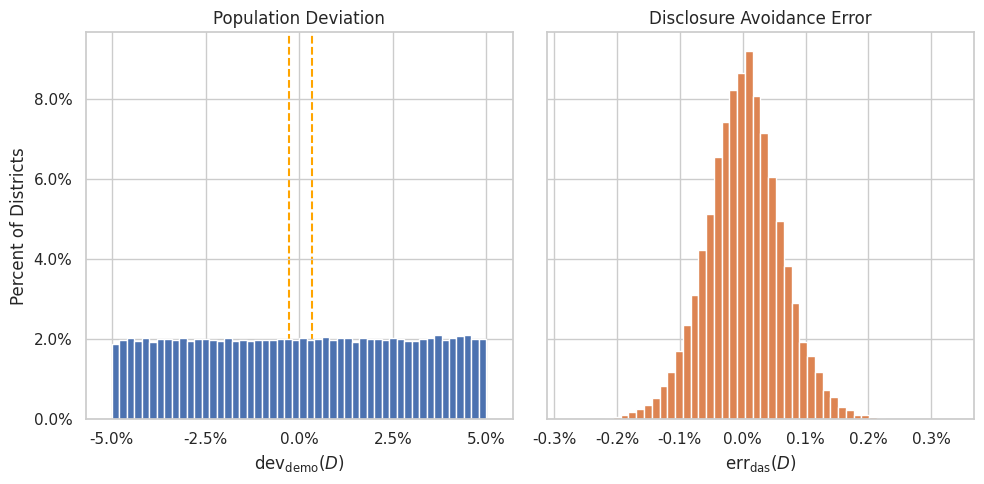

In [61]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)

pop_range = all_dists.TOTPOPdp.max() - all_dists.TOTPOPdp.min()
weights = np.ones(len(all_dists)) / len(all_dists)

# draw orange vertical lines at min(all_dists['ERROR']) and max(all_dists['ERROR'])
# have the lines be behind the histograms
ax[0].axvline(all_dists['ERROR'].min() / ideal_pop, color='orange', linestyle='--', label='min', zorder=0)
ax[0].axvline(all_dists['ERROR'].max() / ideal_pop, color='orange', linestyle='--', label='max', zorder=0)

ax[0].hist((all_dists['TOTPOPdp'] - ideal_pop) / ideal_pop, weights=weights, bins=50, label='SF', color='C0')
ax[0].set_title('Population Deviation')
# ax[0].set_xlabel('Population (Percent of Ideal)')
ax[0].set_xlabel('$\mathsf{dev}_\mathsf{demo}(D)$')
# ax[1].set_ylabel('Count')

ax[0].xaxis.set_ticks([-0.05, -0.025, 0.0, 0.025, 0.05])
ax[0].set_xlim(-0.057, 0.057)

ax[1].hist(all_dists['ERROR'] / ideal_pop, weights=weights, bins=50, label='DP', color='C1')

# show xticks as a percentage
vals = ax[1].get_xticks()
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in vals])

vals = ax[0].get_xticks()
ax[0].set_xticklabels(['{:,.1%}'.format(x) for x in vals])

# format y axis percent
vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax[1].set_title(f'Disclosure Avoidance Error')
# ax[1].set_xlabel('Error (Percent of Ideal)')
ax[1].set_xlabel('$\mathsf{err}_\mathsf{das}(D)$')
ax[0].set_ylabel('Percent of Districts')

plt.tight_layout()
# plt.savefig(f'section1/LA_SS_ensemble_final_lims.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()